In [1]:
import cv2
from PIL import Image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.models import load_model
import numpy as np
from numpy.linalg import inv
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG19
from tensorflow.keras.losses import MeanSquaredError

In [2]:
size = 512
channels = 1  #input image format
input_img = Input(shape=(size, size, channels))

def preprocess_image(image):
    # Check and convert the image to uint8 if it's not in that format
    if image.dtype != np.uint8:
        # Normalize to 0-255 and convert to uint8 if it seems to be in a [0, 1] range
        if image.max() <= 1.0:
            image = (image * 255).astype(np.uint8)
        else:
            image = image.astype(np.uint8)
    # Apply erosion to reduce noise
    kernel = np.ones((3,3), np.uint8)  # Adjust the kernel size as needed
    eroded_image = cv2.erode(image, kernel, iterations=1)
    # Apply edge detection
    edges = cv2.Canny(image, 100, 200)
    
    # Resize the image to match the input shape of the network and add a channel dimension
    resized_image = cv2.resize(edges, (size, size))
    
    # Normalize the image to range [0, 1] for the neural network
    final_image = np.expand_dims(resized_image, axis=-1) / 1.0
    
    return final_image

def custom_preprocessor(img):
    # Assuming 'img' is a NumPy array of image data
    return preprocess_image(img)

# Setup the data generator
datagen = ImageDataGenerator(
    rescale=1./255.0,
    preprocessing_function=custom_preprocessor
)

In [3]:
#load trained model
autoencoder = load_model('0505_2.keras')
#autoencoder = load_model('0504_5.keras')



In [5]:
anomalous_generator = datagen.flow_from_directory(
    'finalTestingAnomalous',  #path to dataset
    target_size=(size, size),
    color_mode='grayscale',
    batch_size=16,
    class_mode='input',
    shuffle = False
)

Found 433 images belonging to 6 classes.


In [25]:
normal_generator = datagen.flow_from_directory(
    'finalTestingNormal',  #path to dataset
    target_size=(size, size),
    color_mode='grayscale',
    batch_size=16,
    class_mode='input',
    shuffle = False
)

Found 78 images belonging to 3 classes.


In [7]:
#test model
predicted_anomalous = autoencoder.predict(anomalous_generator, steps=len(anomalous_generator))


/Users/yong/anaconda3/envs/plard/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 364ms/step


In [27]:
predicted_normal = autoencoder.predict(normal_generator, steps=len(normal_generator))

/Users/yong/anaconda3/envs/plard/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 378ms/step


In [26]:
normal_generator.reset()

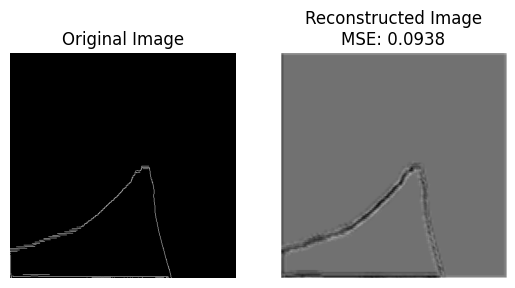

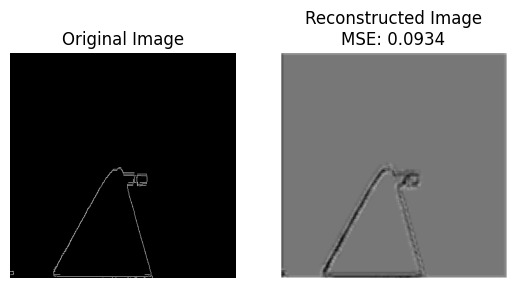

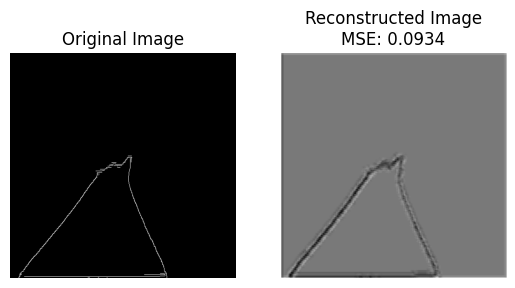

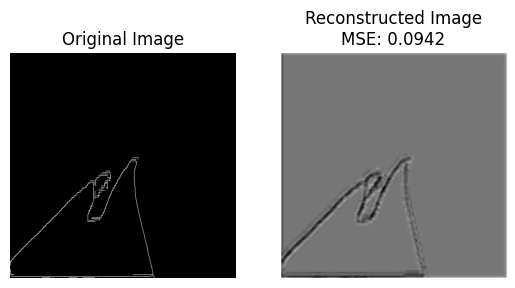

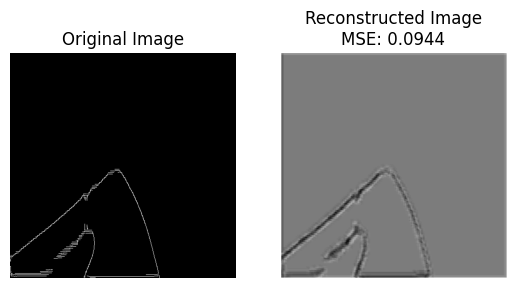

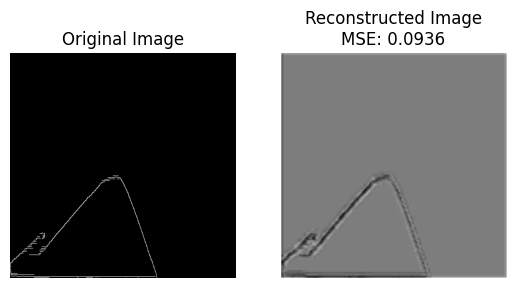

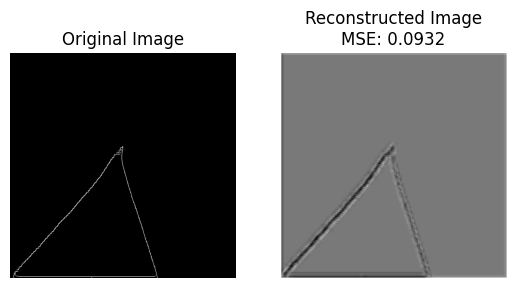

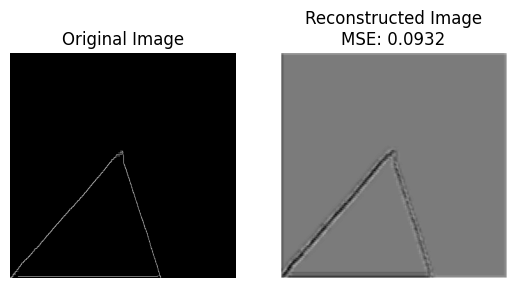

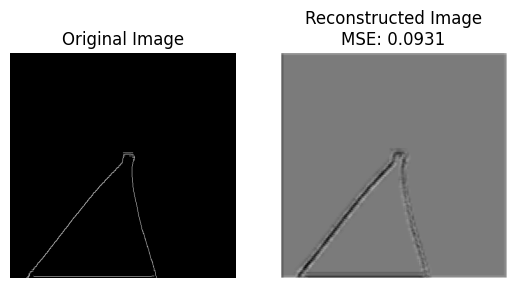

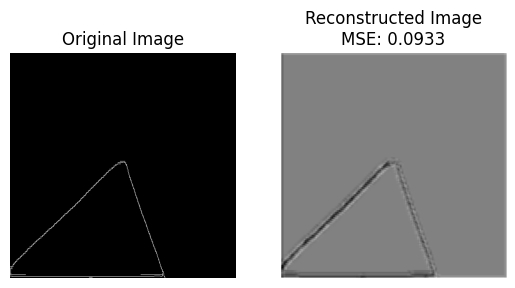

In [28]:
#function to calculate MSE
def mse_loss(original, reconstruction):
    return np.mean((original - reconstruction) ** 2)

#visualize first N images
N = 10

#reset generator
normal_generator.reset()

count = 0
for original_batch, _ in normal_generator:
    for j in range(original_batch.shape[0]):
        if count >= N:
            break

        original_img = original_batch[j]
        predicted_img = predicted_normal[count]

        #calculate the MSE loss
        loss = mse_loss(original_img, predicted_img)

        #plot original image
        plt.subplot(1, 2, 1)
        plt.imshow(original_img.squeeze(), cmap='gray')
        plt.title('Original Image')
        plt.axis('off')

        #plot predicted image
        plt.subplot(1, 2, 2)
        plt.imshow(predicted_img.squeeze(), cmap='gray')
        plt.title(f'Reconstructed Image\nMSE: {loss:.4f}')
        plt.axis('off')

        plt.show()

        count += 1
    if count >= N:
        break 

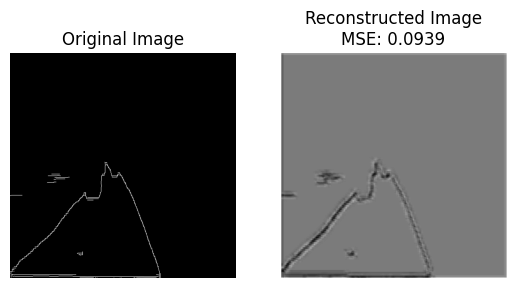

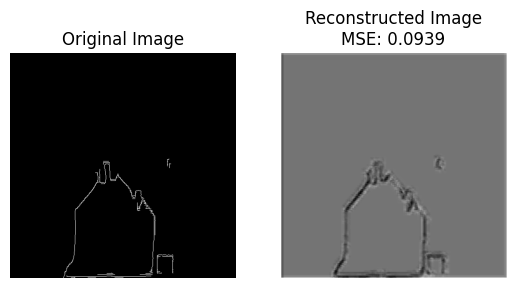

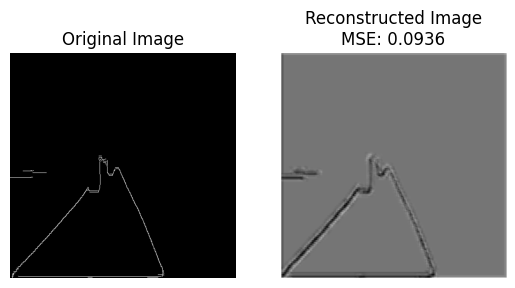

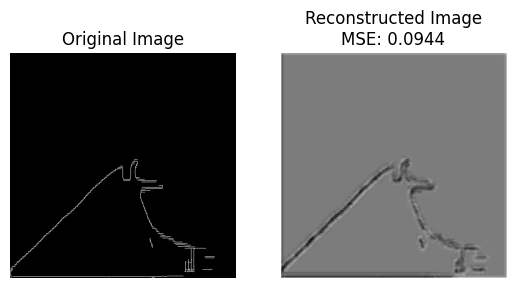

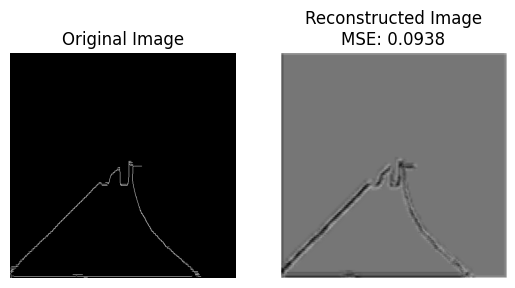

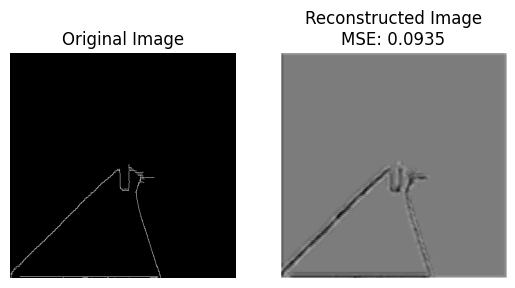

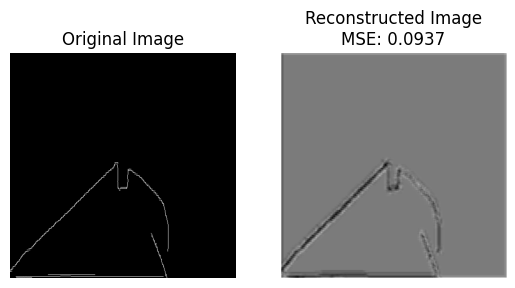

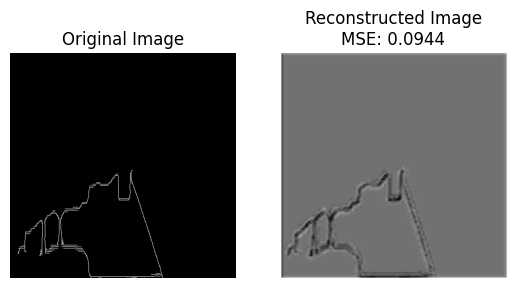

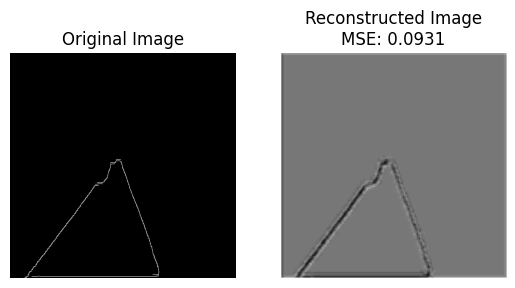

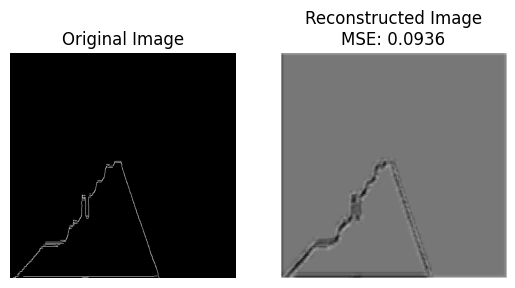

In [10]:
#function to calculate MSE
def mse_loss(original, reconstruction):
    return np.mean((original - reconstruction) ** 2)

#visualize first N images
N = 10

count = 0
for original_batch, _ in anomalous_generator:
    for j in range(original_batch.shape[0]):
        if count >= N:
            break

        original_img = original_batch[j]
        predicted_img = predicted_anomalous[count]

        #calculate the MSE loss
        loss = mse_loss(original_img, predicted_img)

        #plot original image
        plt.subplot(1, 2, 1)
        plt.imshow(original_img.squeeze(), cmap='gray')
        plt.title('Original Image')
        plt.axis('off')

        #plot predicted image
        plt.subplot(1, 2, 2)
        plt.imshow(predicted_img.squeeze(), cmap='gray')
        plt.title(f'Reconstructed Image\nMSE: {loss:.4f}')
        plt.axis('off')

        plt.show()

        count += 1
    if count >= N:
        break 

In [11]:
#calculate MSE
def mse_loss(original, reconstruction):
    return np.mean(np.square(original - reconstruction))

def calculate_mse_values(model, generator):
    # Calculate the number of steps required to process all images
    num_samples = generator.samples
    batch_size = generator.batch_size
    steps = (num_samples + batch_size - 1) // batch_size  # Ensure all samples are covered
    print(f"Total samples: {num_samples}, Batch size: {batch_size}, Steps: {steps}")

    # Get predictions for the test images
    predicted_images = model.predict(generator, steps=steps)

    # Ensure the generator is properly reset for consistent image fetching
    generator.reset()

    # Initialize MSE values array
    mse_values = []
    count = 0

    # Process each batch
    for original_batch, _ in generator:
        for j in range(original_batch.shape[0]):
            # Check to prevent index out-of-bound error
            if count >= len(predicted_images):
                print(f"Stopping early: reached end of predicted images at count {count}")
                break

            original_img = original_batch[j]
            predicted_img = predicted_images[count]

            # Calculate MSE and store it
            loss = mse_loss(original_img, predicted_img)
            mse_values.append(loss)

            count += 1
        if count >= len(predicted_images):
                print(f"Stopping early: reached end of predicted images at count {count}")
                break

    print(f"Processed {count} images.")
    return mse_values


Total samples: 433, Batch size: 16, Steps: 28
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 331ms/step
Stopping early: reached end of predicted images at count 433
Processed 433 images.


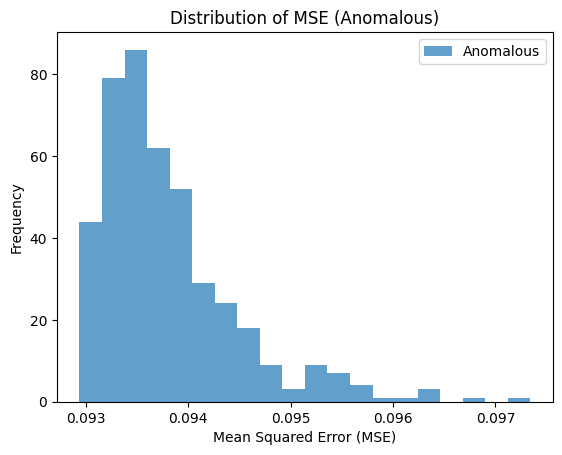

In [12]:
#anomalous MSE distribution plot 
anomalous = calculate_mse_values(autoencoder, anomalous_generator)
plt.hist(anomalous, bins=20, alpha=0.7, label='Anomalous')
plt.xlabel('Mean Squared Error (MSE)')
plt.ylabel('Frequency')
plt.title('Distribution of MSE (Anomalous)')
plt.legend()

plt.show()

Total samples: 78, Batch size: 16, Steps: 5
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 346ms/step
Stopping early: reached end of predicted images at count 78
Processed 78 images.


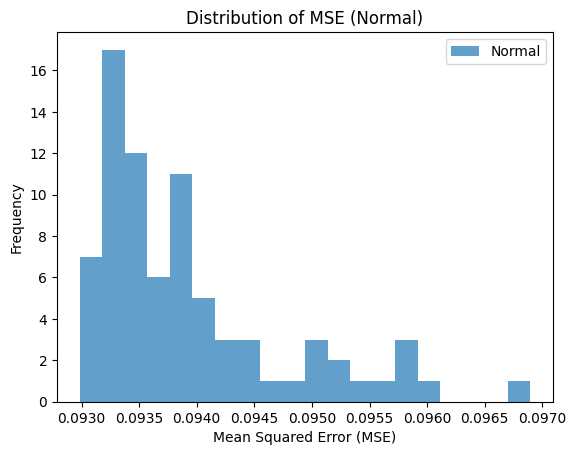

In [13]:
#normal MSE distribution plot 
normal = calculate_mse_values(autoencoder, normal_generator)
plt.hist(normal, bins=20, alpha=0.7, label='Normal')
plt.xlabel('Mean Squared Error (MSE)')
plt.ylabel('Frequency')
plt.title('Distribution of MSE (Normal)')
plt.legend()

plt.show()

In [29]:
threshold = 0.0933

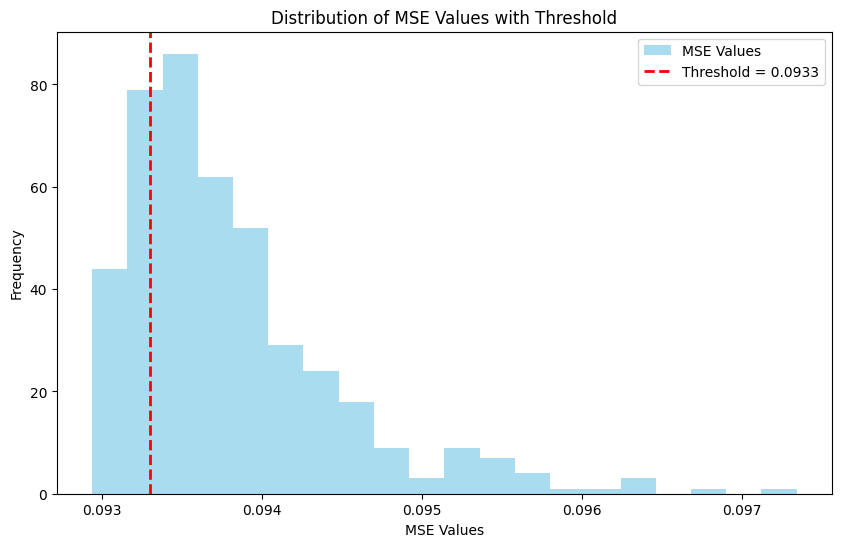

Percentage of MSE values above the threshold: 77.83%
433


In [30]:
def analyze_mse_anomalous(mse_values, threshold):
    """
    Analyzes and plots the MSE values to show how many are on or below a given threshold.
    
    Args:
    mse_values (list or array): The MSE values.
    threshold (float): The threshold value for comparison.
    
    Returns:
    float: The percentage of MSE values on or below the threshold.
    """
    # Calculate the number of MSE values on or below the threshold
    above_threshold = [mse for mse in mse_values if mse > threshold]
    percentage_below = (len(above_threshold) / len(mse_values)) * 100
    
    # Plotting the results
    plt.figure(figsize=(10, 6))
    plt.hist(mse_values, bins=20, color='skyblue', alpha=0.7, label='MSE Values')
    plt.axvline(x=threshold, color='red', linestyle='dashed', linewidth=2, label=f'Threshold = {threshold}')
    plt.xlabel('MSE Values')
    plt.ylabel('Frequency')
    plt.title('Distribution of MSE Values with Threshold')
    plt.legend()
    plt.show()
    
    return percentage_below

percentage = analyze_mse_anomalous(anomalous, threshold)
print(f"Percentage of MSE values above the threshold: {percentage:.2f}%")
print(len(anomalous))


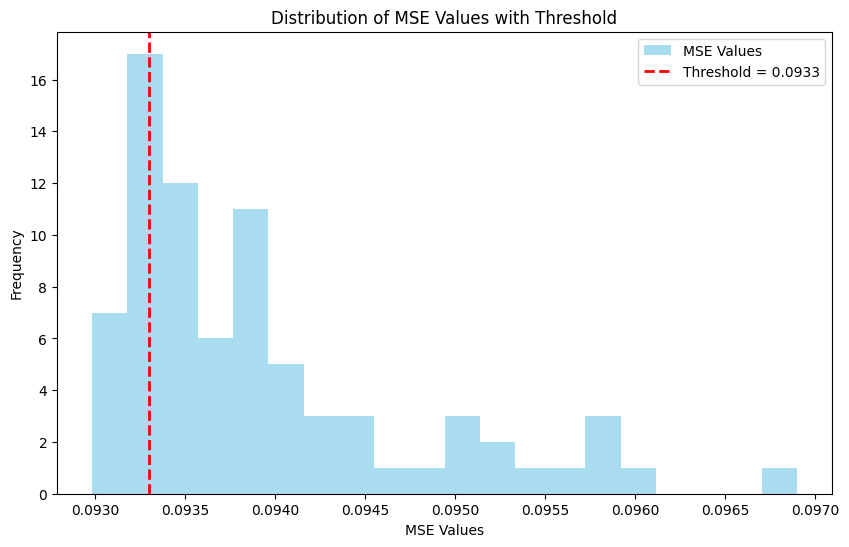

Percentage of MSE values on or below the threshold: 21.79%


In [31]:
def analyze_mse_normal(mse_values, threshold):
    """
    Analyzes and plots the MSE values to show how many are on or below a given threshold.
    
    Args:
    mse_values (list or array): The MSE values.
    threshold (float): The threshold value for comparison.
    
    Returns:
    float: The percentage of MSE values on or below the threshold.
    """
    # Calculate the number of MSE values on or below the threshold
    below_threshold = [mse for mse in mse_values if mse <= threshold]
    percentage_below = (len(below_threshold) / len(mse_values)) * 100
    
    # Plotting the results
    plt.figure(figsize=(10, 6))
    plt.hist(mse_values, bins=20, color='skyblue', alpha=0.7, label='MSE Values')
    plt.axvline(x=threshold, color='red', linestyle='dashed', linewidth=2, label=f'Threshold = {threshold}')
    plt.xlabel('MSE Values')
    plt.ylabel('Frequency')
    plt.title('Distribution of MSE Values with Threshold')
    plt.legend()
    plt.show()
    
    return percentage_below

percentage = analyze_mse_normal(normal, threshold)
print(f"Percentage of MSE values on or below the threshold: {percentage:.2f}%")


In [5]:
trained_data = autoencoder.predict(train_generator)
#you need to reshape it to (samples, features)
trained_data_flat = trained_data.reshape(trained_data.shape[0], -1)
#calculate mean
mean = np.mean(trained_data_flat, axis=0)
# Assuming you decide how many components you need based on explained variance
pca = PCA(n_components=80)  # Adjust n_components based on your specific needs
trained_data_reduced = pca.fit_transform(trained_data_flat)
# Calculate the covariance matrix with regularization
regularization_term = 1e-6
cov_encoded = np.cov(trained_data_reduced, rowvar=False)
cov_encoded += np.eye(cov_encoded.shape[0]) * regularization_term
inv_covmat = np.linalg.inv(cov_encoded)

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 395ms/step


In [10]:
encoder = Model(inputs=autoencoder.input,
                      outputs=autoencoder.layers[2].output)

In [19]:
mean, inv_covmat = calculate_mean_and_covariance(autoencoder,train_generator)

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 360ms/step


: 

In [17]:
# Function to calculate the Mahalanobis distance
def mahalanobis_distance(x, mean, inv_covmat):
    x_minus_mu = x - mean
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahalanobis_dist = np.sqrt(np.dot(left_term, x_minus_mu.T))
    return mahalanobis_dist

# Function to calculate mean and inverse covariance matrix from training data
def calculate_mean_and_covariance(model, generator):
    encoded_images = model.predict(generator)
    encoded_images_flattened = encoded_images.reshape(encoded_images.shape[0], -1)
    print("After reshaping, flattened encoded images shape:", encoded_images_flattened.shape)
    mean_encoded = np.mean(encoded_images_flattened, axis=0)
    cov_encoded = np.cov(encoded_images_flattened, rowvar=False)
    inv_covmat = np.linalg.inv(cov_encoded)
    return mean_encoded, inv_covmat

# Function to calculate Mahalanobis distances for new data
def calculate_mahalanobis_values(encoder_model, mse_model, generator, mean_encoded, inv_covmat):
    num_samples = generator.samples
    batch_size = generator.batch_size
    steps = (num_samples + batch_size - 1) // batch_size
    print(f"Total samples: {num_samples}, Batch size: {batch_size}, Steps: {steps}")

    # Get predictions for the test images
    predicted_images = mse_model.predict(generator, steps=steps)
    
    # Ensure the generator is properly reset for consistent image fetching
    generator.reset()

    # Initialize Mahalanobis distance values array
    mahalanobis_values = []
    count = 0

    # Process each batch
    for original_batch, _ in generator:
        encoded_images = encoder_model.predict(original_batch)
        
        # Flatten each encoded image to match the mean vector
        encoded_images_flattened = encoded_images.reshape(encoded_images.shape[0], -1)
        
        for j in range(encoded_images_flattened.shape[0]):
            if count >= len(predicted_images):
                print(f"Stopping early: reached end of predicted images at count {count}")
                break

            encoded_img = encoded_images_flattened[j]

            # Calculate Mahalanobis distance and store it
            distance = mahalanobis_distance(encoded_img, mean_encoded, inv_covmat)
            mahalanobis_values.append(distance)

            count += 1
        if count >= len(predicted_images):
            print(f"Stopping early: reached end of predicted images at count {count}")
            break

    print(f"Processed {count} images.")
    return mahalanobis_values


In [18]:
#normal MSE distribution plot 
testing = calculate_mahalanobis_values(encoder, autoencoder, train_generator, mean, inv_covmat)
plt.hist(testing, bins=20, alpha=0.7, label='Normal')
plt.xlabel('Mean Squared Error (MSE)')
plt.ylabel('Frequency')
plt.title('Distribution of MSE (Normal)')
plt.legend()

plt.show()

Total samples: 80, Batch size: 16, Steps: 5
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 390ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


ValueError: operands could not be broadcast together with shapes (1851072,) (462768,) 